# Fake Object injection

The intent of this notebook is to provide a fake object injection framework into HFF images.
This is done in order to characterize the uncertainties in the flux and color measurements.

We use `GalSim` and the COSMOS catalog provided by Iary Davizson and matched to `GalSim`'s catalog.

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import astropy.table
from astropy.io import fits
import fitsio
import galsim
import astropy.units as u
import os
import glob
from astropy.wcs import WCS

Clusters and filters in which we are going to simulate stuff

In [4]:
clusters = ['A370', 'A2744', 'AS1063', 'M0416', 'M0717', 'M1149']

In [5]:
filters = ['F105W', 'F125W', 'F140W', 'F160W', 'F275W', 'F336W', 'F435W', 'F606W',
           'F814W', 'I1', 'I2', 'I3', 'I4', 'Ks' ]
#filters = ['F105W', 'F125W', 'F140W', 'F160W', 'F435W', 'F606W',
#           'F814W', 'I1', 'I2', 'I3', 'I4', 'Ks' ]

Basic locations of data

In [6]:
base_path = '../Downloads/GALSIM/'

Photometric zeropoints

In [7]:
zeropoints = {
        'F275W': 24.1314,
        'F336W': 24.6659,
        'F435W': 25.6656,
        'F606W': 26.4934,
        'F814W': 25.9467,
        'F105W': 26.2689,
        'F125W': 26.2303,
        'F140W': 26.4524,
        'F160W': 25.9463,
        'Ks': 26.0,
        'I1': 21.5814,
        'I2': 21.5814,
        'I3': 21.5814,
        'I4': 21.5814,
    }

In [8]:
#Initialize GalSim's COSMOS catalog (this subselects from real_galaxy_catalog_25.2.fits so we have to match later to Iary's catalog)
cosmos_cat = galsim.COSMOSCatalog('real_galaxy_catalog_25.2.fits',
                                      dir='../Downloads/COSMOS_25.2_training_sample/')

In [9]:
def generate_fake_stars(cluster, bands=['F160W'], nobj=1, pixel_scale=0.06,
                        zeropoints=zeropoints, use_segmap=True,
                        base_path=base_path, 
                        min_mag=23, max_mag=30, ireal=1):
    if cluster!='A370':
        wgt_path = os.path.join(base_path, f'{cluster}_IR-WEIGHTED_RMS.fits')
    else:
        wgt_path = os.path.join(base_path, f'{cluster}_IR-WEIGHTED_RMS_convolved.fits')
    wgtmap = fitsio.read(wgt_path) < 1000
    meta = fitsio.read_header(wgt_path)
    #pixel_scale = 0.03 #Pixel scale in arcseconds
    image_x = meta['NAXIS1']
    image_y = meta['NAXIS2']
    full_image = galsim.ImageF(image_x, image_y)
    full_image.setOrigin(0,0)
    imgmask = wgtmap
    psfs = dict()
    segmask = np.ones_like(imgmask)
    for band in bands:
        if use_segmap:
            for mode in ['hot', 'cold']:
                segmap_path = os.path.join(base_path, f'{cluster}-clu_{band}_{cluster}_{mode}_SEG.fits')
                segmask = (segmask) & (fitsio.read(segmap_path) == 0)
        
        imgmask = imgmask & segmask
        #psfname = os.path.join(base_path, 'PSFs',
        #                       f'{cluster}_{band}_psf_39x39.fits')
        if band not in ['I1','I2', 'I3', 'I4', 'Ks']:
            #psfname = os.path.join(base_path, f'{cluster}_{band}_psf_39x39.fits')
            psfname = os.path.join('/Users/jsanch87/Downloads',f'M0416_{band}_psf_39x39.fits')
        elif 'I' in band:
            psfname = glob.glob(os.path.join(base_path, f'{cluster}_{band}*_PRF.fits'))[0]
        elif 'K' in band:
            psfname = glob.glob(os.path.join(base_path, f'{cluster}_Kdriz_psf_39x39.fits'))[0]
        psfs[band] = galsim.InterpolatedImage(psfname, scale = pixel_scale, flux = 1.)
    img_px = np.where(imgmask)
    random_indices = np.random.choice(np.arange(len(img_px[0])), size=nobj)
    dx = img_px[1][random_indices]
    dy = img_px[0][random_indices]
    nx = int(50/pixel_scale) #We draw only postage stamps of 10"
    ny = nx
    all_images = dict()
    mag = min_mag+(max_mag-min_mag)*np.random.random(size=nobj)
    #Check http://www.stsci.edu/hst/acs/analysis/zeropoints for the total_flux calculation
    total_flux = 10**(-0.4*(mag+2.408+5*np.log10(meta['PHOTPLAM'])))/meta['PHOTFLAM']
    for band in bands:
        full_image = galsim.ImageF(image_x, image_y)
        full_image.setOrigin(0,0)
        for i in range(0,nobj):
            star = galsim.Gaussian(sigma=1e-12, flux=total_flux[i])
            final = galsim.Convolve(psfs[band], star)
            b = galsim.BoundsI(int(dx[i]-nx/2.), int(dx[i]+nx/2.), int(dy[i]-ny/2.), int(dy[i]+ny/2.))
            stamp = final.drawImage(image=full_image[b], method='no_pixel',dtype=float32, add_to_image=True)
            #if i%10==0:
            #    print(mag[i], total_flux[i], dx[i], dy[i])
        all_images[band] = full_image
        if use_segmap:
            full_image.write(os.path.join(base_path,'images_unblended', 
                                          f'image_fake_stars_{cluster}_{band}_{min_mag}_{max_mag}_{ireal}.fits.gz'))
        else:
            full_image.write(os.path.join(base_path,'images_blended', 
                                          f'image_fake_stars_{cluster}_{band}_{min_mag}_{max_mag}_{ireal}.fits.gz'))

    tab = astropy.table.Table([np.arange(len(mag)),dx,dy,total_flux,mag],
                              names=('ID','X','Y','TOTAL_FLUX','MAG'))
    if use_segmap:
        tab.write(os.path.join(base_path,'catalogs_unblended', f'catalog_fake_stars_{cluster}_{min_mag}_{max_mag}_{ireal}.dat'),format='ascii',overwrite=True)
    else:
        tab.write(os.path.join(base_path,'catalogs_blended', f'catalog_fake_stars_{cluster}_{min_mag}_{max_mag}_{ireal}.dat'),format='ascii',overwrite=True)
    #hdulist[0].data = full_image.array+hdulist[0].data
    #hdulist.writeto(os.path.join(path,'image_fake_'+filter_name+'_nobj_'+str(nobj)+'_'+str(min_mag)+'.fits.gz'),overwrite=True)
    return all_images, dx, dy

In [10]:
for i in range(0,1):
    _, _, _ = generate_fake_stars('A2744', nobj=150, ireal=i, use_segmap=False)

OSError: FITSIO status = 104: could not open the named file
failed to find or open the following file: (ffopen)
../Downloads/GALSIM/A2744_IR-WEIGHTED_RMS.fits


In [11]:
# We filter the original catalog with the indices provided by cosmos_cat.orig_indices to get the `IDENT` values
original_catalog = astropy.table.Table.read('../Downloads/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits')[cosmos_cat.orig_index]
iarys_catalog = astropy.table.Table.read('../Downloads/Completeness_and_Errors/COSMOS_training_catalog_25.3wHSTbands.fits.gz')

In [12]:
# Index in the cosmos_cat object of the galaxies to simulate that are in Iary's catalog
good_idx = np.where(np.in1d(original_catalog['IDENT'], iarys_catalog['IDENT']))[0]

In [13]:
def prepare_galaxies(nobj):
    galaxy_idx = np.random.choice(good_idx, size=nobj)
    galaxy_ids = original_catalog['IDENT'][galaxy_idx]
    gal_list = cosmos_cat.makeGalaxy(gal_type='parametric', index=galaxy_idx) # List with the COSMOS galaxies
    beta=2.0*np.pi*np.random.random(size=nobj)
    beta = beta*galsim.radians
    gal_fluxes = dict()
    for band in filters:
        gal_fluxes[band]=np.zeros(len(galaxy_idx))
        for i in range(nobj):
            if 'I' not in band:
                gal_fluxes[band][i] = iarys_catalog[f'{band}_lr'][iarys_catalog['IDENT']==galaxy_ids[i]]
            else:
                gal_fluxes[band][i] = iarys_catalog[f'{band.lower()}_lr'][iarys_catalog['IDENT']==galaxy_ids[i]]
    flux_counts = dict()
    for band in filters:
        _mag = (gal_fluxes[band]*u.uJy).to(u.ABmag)
        _mag = _mag.value
        flux_counts[band] = 10**(-0.4*(_mag-zeropoints[band]))
    return gal_list, beta, flux_counts

In [768]:
# Generate nobj samples
nobj = 80
galaxy_idx = np.random.choice(good_idx, size=nobj)
galaxy_ids = original_catalog['IDENT'][galaxy_idx]
gal_list = cosmos_cat.makeGalaxy(gal_type='parametric', index=galaxy_idx) # List with the COSMOS galaxies
#gal_list = galsim.RealGalaxy(cat, index=galaxy_idx)
beta=2.0*np.pi*np.random.random(size=nobj)
beta = beta*galsim.radians

In [769]:
# Get the fluxes (Iary's catalog is in uJy)
gal_fluxes = dict()
for band in filters:
    gal_fluxes[band]=np.zeros(len(galaxy_idx))
    for i in range(nobj):
        if 'I' not in band:
            gal_fluxes[band][i] = iarys_catalog[f'{band}_lr'][iarys_catalog['IDENT']==galaxy_ids[i]]
        else:
            gal_fluxes[band][i] = iarys_catalog[f'{band.lower()}_lr'][iarys_catalog['IDENT']==galaxy_ids[i]]

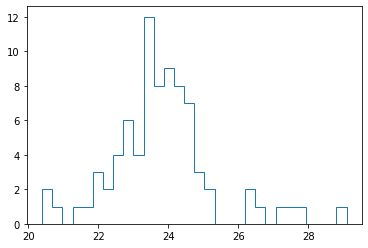

In [770]:
# Get the fluxes (Iary's catalog is in uJy)
flux_counts = dict()
for band in filters:
    _mag = (gal_fluxes[band]*u.uJy).to(u.ABmag)
    _mag = _mag.value+2
    #print(band, zeropoints[band])
    flux_counts[band] = 10**(-0.4*(_mag-zeropoints[band]))
    #print(flux_counts[band], _mag)
    if 'F160' in band:
        plt.hist(_mag, bins=30, histtype='step')

In [704]:
import astropy.io.fits

Text(0, 0.5, 'P(HLR)')

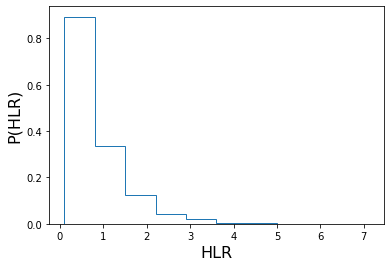

In [771]:
plt.hist(0.1+np.random.exponential(0.7,size=10000), histtype='step', density=True)
plt.xlabel('HLR', fontsize=16)
plt.ylabel('P(HLR)', fontsize=16)

In [772]:
#gal_list2 = dict()
#for band in filters:
gal_list2=[]
for i in range(0,nobj):
    disk_frac = 1.0-np.random.random()
    _beta = galsim.Angle(np.pi*np.random.random(), unit=galsim.radians)
    _bulge = galsim.Sersic(2, half_light_radius=0.1+np.random.exponential(0.7), flux=(1-disk_frac)*gal_fluxes['F160W'][i])
    _disk = galsim.Sersic(4, half_light_radius=0.1+np.random.exponential(0.7), flux=disk_frac*gal_fluxes['F160W'][i])
    _bulge.shear(q=0.1+0.9*np.random.random(), beta=_beta)
    _disk.shear(q=0.1+0.9*np.random.random(), beta=_beta)
    gal_list2.append(_bulge+_disk)

In [788]:
def generate_fake_objects(bands, cluster, gal_list, beta, flux_counts, nobj,
                          base_path=base_path,
                          niter=0, pixel_scale=0.06, method='no_pixel', gal_type='real', flux_rescale=True):
    if cluster!='A370':
        try:
            wgt_path = glob.glob(os.path.join(base_path, f'{cluster}*RMS*.fits'))[0]
        except:
            wgt_path = os.path.isfile(os.path.join(base_path, f'{cluster}_IR-WEIGHTED_RMS.fits'))
            wgt_path = glob.glob(os.path.join(base_path, f'{cluster}*RMS*.fits'))[0]
    else:
        try:
            wgt_path = glob.glob(os.path.join(base_path, f'{cluster}*RMS*.fits'))[0]
        except:
            wgt_path = os.path.join(base_path, f'{cluster}_IR-WEIGHTED_RMS_convolved.fits')
    wgtmap = fitsio.read(wgt_path) < 1000
    meta = fitsio.read_header(wgt_path)
    ks_path = os.path.join(base_path, f'KIFF_{cluster}-clu_Ks_v1.0_rms.fits')
    if 'AS' in cluster:
        irac_path = f'../Downloads/RMS/RXCJ2248.IRAC.1.mosaic.fits'
    else:
        irac_path = os.path.join(base_path, f'{cluster}.irac.1.mosaic_unc_Corrected.fits')
    meta_irac = fitsio.read_header(irac_path)
    meta_ks = fitsio.read_header(ks_path)
    wcs_orig = WCS(wgt_path)
    wcs_irac = WCS(meta_irac)
    wcs_ks = WCS(meta_ks)
    #pixel_scale = 0.03 #Pixel scale in arcseconds
    image_x = meta['NAXIS1']
    image_y = meta['NAXIS2']
    image_x_irac = meta_irac['NAXIS1']
    image_y_irac = meta_irac['NAXIS2']
    image_x_ks = meta_ks['NAXIS1']
    image_y_ks = meta_ks['NAXIS2']
    #print(image_x_ks, image_y_ks)
    psfs = dict()
    img_px = np.where(wgtmap)
    random_indices = np.random.choice(np.arange(len(img_px[0])), size=nobj)
    dx = img_px[1][random_indices]
    dy = img_px[0][random_indices]
    ra, dec = wcs_orig.all_pix2world(dx, dy, 0)
    dx_irac, dy_irac = wcs_irac.all_world2pix(ra, dec, 0)
    dx_k, dy_k = wcs_ks.all_world2pix(ra, dec, 0)
    nx = int(30/pixel_scale) #We draw only postage stamps of 15"
    ny = nx
    for band in bands:
        if band not in ['I1','I2', 'I3', 'I4', 'Ks']:
            psfname = os.path.join(base_path, f'{cluster}_{band}_psf_39x39.fits')
            #psfname = os.path.join('/Users/jsanch87/Downloads',f'M0416_{band}_psf_39x39.fits')
            #psfname = os.path.join('/Users/jsanch87/Downloads/Completeness_and_Errors/PSFs',
            #                       f'{cluster}_{band}_psf_39x39.fits')
        elif 'I' in band:
            psfname = glob.glob(os.path.join(base_path, f'{cluster}_{band}*_PRF.fits'))[0]
        elif 'K' in band:
            psfname = glob.glob(os.path.join(base_path, f'{cluster}_Kdriz_psf_39x39.fits'))[0]
        psfs[band] = galsim.InterpolatedImage(psfname, scale = pixel_scale, flux = 1.)
    weights = dict()
    rendered_fluxes = dict()
    for band in bands:
        print('Generating band: ', band)
        if band not in ['I1','I2', 'I3', 'I4', 'Ks']:
            _wcs = wcs_orig
            full_image = galsim.ImageF(image_x, image_y)
            full_image.setOrigin(0,0)
            if ('A' in cluster) and ('AS' not in cluster):
                cluster_no = cluster.split('A')[1]
            elif 'AS' in cluster:
                cluster_no = cluster.split('AS')[1]
            elif 'M' in cluster:
                cluster_no = cluster.split('M')[1]
            #print(cluster_no)
            wgt_path = glob.glob(os.path.join(base_path, f'hlsp_*{cluster_no}_{band.lower()}*rms.fits'))[0]
            wgt_map = fitsio.read(wgt_path)
        elif 'I' in band:
            _wcs = wcs_irac
            full_image = galsim.ImageF(image_x_irac, image_y_irac)
            full_image.setOrigin(0,0)
            band_no = band.split('I')[1]
            if 'AS' in cluster:
                wgt_path = glob.glob(f'../Downloads/RMS/RXCJ2248.*.{band_no}.mosaic.fits')[0]
            else:
                wgt_path = glob.glob(os.path.join(base_path, f'{cluster}.*.{band_no}.mosaic*.fits'))[0]
            wgt_map = fitsio.read(wgt_path)
        elif 'K' in band:
            _wcs = wcs_ks
            full_image = galsim.ImageF(image_x_ks, image_y_ks)
            full_image.setOrigin(0,0)
            wgt_path = glob.glob(os.path.join(base_path, f'KIFF_{cluster}-clu_Ks_v1.0_rms.fits'))[0]
            wgt_map = fitsio.read(wgt_path)
        weights[f'weight_{band}']=np.ones(len(gal_list))
        rflux=np.zeros(len(gal_list))
        for i in range(len(gal_list)):
            if 'I' in band:
                psfs[band].shift(7,-4)
            if 'sersic' in gal_type:
                if flux_rescale:
                    gal_list2[i].flux_rescale = gal_fluxes[band][i]/gal_list2[i].flux
                else:
                    gal_list2[i]*= gal_fluxes[band][i]/gal_list2[i].flux
                final = galsim.Convolve(psfs[band], gal_list2[i])
            if 'real' in gal_type:
                if flux_rescale:
                    gal_list[i].flux_rescale = gal_fluxes[band][i]/gal_list[i].flux
                else:
                    gal_list[i]*=gal_fluxes[band][i]/gal_list[i].flux
                gal_list[i].rotate(beta[i])
                final = galsim.Convolve(psfs[band], gal_list[i])
            #final = galsim.Convolve(final, galsim.Gaussian(sigma=0.12))
            if band not in ['I1','I2', 'I3', 'I4','Ks']:
                b = galsim.BoundsI(int(dx[i]-nx/2.), int(dx[i]+nx/2.), int(dy[i]-ny/2.), int(dy[i]+ny/2.))
                stamp = final.drawImage(image=full_image[b], method=method, dtype=float32, add_to_image=True, scale=0.06)
                if wgt_map[dy[i], dx[i]] > 1000:
                    weights[f'weight_{band}'][i]=0.
            elif 'I' in band:
                b = galsim.BoundsI(int(dx_irac[i]-nx/2.), int(dx_irac[i]+nx/2.), int(dy_irac[i]-ny/2.), int(dy_irac[i]+ny/2.))
                stamp = final.drawImage(image=full_image[b], scale=0.6, dtype=float32, add_to_image=True, method=method)
                if wgt_map[int(dy_irac[i]), int(dx_irac[i])] > 1000:
                    weights[f'weight_{band}'][i]=0.
            elif 'K' in band:
                b = galsim.BoundsI(int(dx_k[i]-nx/2.), int(dx_k[i]+nx/2.), int(dy_k[i]-ny/2.), int(dy_k[i]+ny/2.))
                stamp = final.drawImage(image=full_image[b], method=method, dtype=float32, add_to_image=True, scale=0.06)
                if wgt_map[int(dy_k[i]), int(dx_k[i])] > 1000:
                    weights[f'weight_{band}'][i]=0.
            rflux[i] = np.sum(stamp.array)
        #rendered_fluxes[band] = rflux
        rendered_fluxes[band] = gal_fluxes[band]
        hdu = fits.PrimaryHDU(data=full_image.array, header=_wcs.to_header())
        hdu.writeto(os.path.join(base_path, 'output', f'fake_galaxies_{cluster}_{band}_{niter}_{gal_type}.fits.gz'), overwrite=True)
        #full_image.write(os.path.join(base_path, 'output', f'fake_galaxies_{cluster}_{band}_{niter}.fits.gz'))
        
    _tab_pos = astropy.table.Table([dx, dy, dx_irac, dy_irac, dx_k, dy_k, ra, dec], 
                                   names=('X','Y', 'X_IRAC', 'Y_IRAC', 'X_KS', 'Y_KS', 'RA', 'DEC'))
    _tab_flux = astropy.table.Table(rendered_fluxes)
    _tab_weights = astropy.table.Table(weights)
    tab_out = astropy.table.hstack([_tab_pos, _tab_flux, _tab_weights])
    tab_out.write(os.path.join(base_path,'output', f'catalog_fake_galaxies_{cluster}_{niter}_{gal_type}.dat'), format='ascii', overwrite=True)

In [774]:
def generate_fake_stars_hff(bands, cluster, nobj,
                          base_path=base_path,
                          niter=0, pixel_scale=0.06, box_size=20, min_mag=21.5, max_mag=28):
    if cluster!='A370':
        try:
            wgt_path = glob.glob(os.path.join(base_path, f'{cluster}*RMS*.fits'))[0]
        except:
            wgt_path = os.path.isfile(os.path.join(base_path, f'{cluster}_IR-WEIGHTED_RMS.fits'))
            wgt_path = glob.glob(os.path.join(base_path, f'{cluster}*RMS*.fits'))[0]
    else:
        try:
            wgt_path = glob.glob(os.path.join(base_path, f'{cluster}*RMS*.fits'))[0]
        except:
            wgt_path = os.path.join(base_path, f'{cluster}_IR-WEIGHTED_RMS_convolved.fits')
    wgtmap = fitsio.read(wgt_path) < 1000
    meta = fitsio.read_header(wgt_path)
    ks_path = os.path.join(base_path, f'KIFF_{cluster}-clu_Ks_v1.0_rms.fits')
    if 'AS' in cluster:
        irac_path = f'../Downloads/RMS/RXCJ2248.IRAC.1.mosaic.fits'
    else:
        irac_path = os.path.join(base_path, f'{cluster}.irac.1.mosaic_unc_Corrected.fits')
    meta_irac = fitsio.read_header(irac_path)
    meta_ks = fitsio.read_header(ks_path)
    wcs_orig = WCS(wgt_path)
    wcs_irac = WCS(meta_irac)
    wcs_ks = WCS(meta_ks)
    #pixel_scale = 0.03 #Pixel scale in arcseconds
    image_x = meta['NAXIS1']
    image_y = meta['NAXIS2']
    image_x_irac = meta_irac['NAXIS1']
    image_y_irac = meta_irac['NAXIS2']
    image_x_ks = meta_ks['NAXIS1']
    image_y_ks = meta_ks['NAXIS2']
    #print(image_x_ks, image_y_ks)
    psfs = dict()
    img_px = np.where(wgtmap)
    random_indices = np.random.choice(np.arange(len(img_px[0])), size=nobj)
    dx = img_px[1][random_indices]
    dy = img_px[0][random_indices]
    ra, dec = wcs_orig.all_pix2world(dx, dy, 0)
    dx_irac, dy_irac = wcs_irac.all_world2pix(ra, dec, 0)
    dx_k, dy_k = wcs_ks.all_world2pix(ra, dec, 0)
    nx = int(box_size/pixel_scale) #We draw only postage stamps of 15"
    ny = nx
    for band in bands:
        if band not in ['I1','I2', 'I3', 'I4', 'Ks']:
            psfname = os.path.join(base_path, f'{cluster}_{band}_psf_39x39.fits')
            #psfname = os.path.join('/Users/jsanch87/Downloads',f'M0416_{band}_psf_39x39.fits')
            #psfname = os.path.join('/Users/jsanch87/Downloads/Completeness_and_Errors/PSFs', f'{cluster}_{band}_psf_39x39.fits')
        elif 'I' in band:
            psfname = glob.glob(os.path.join(base_path, f'{cluster}_{band}*_PRF.fits'))[0]
        elif 'K' in band:
            psfname = glob.glob(os.path.join(base_path, f'{cluster}_Kdriz_psf_39x39.fits'))[0]
        psfs[band] = galsim.InterpolatedImage(psfname, scale = pixel_scale, flux = 1.)
    weights = dict()
    rendered_fluxes = dict()
    for band in bands:
        print('Generating band: ', band)
        if band not in ['I1','I2', 'I3', 'I4', 'Ks']:
            full_image = galsim.ImageF(image_x, image_y)
            full_image.setOrigin(0,0)
            if ('A' in cluster) and ('AS' not in cluster):
                cluster_no = cluster.split('A')[1]
            elif 'AS' in cluster:
                cluster_no = cluster.split('AS')[1]
            elif 'M' in cluster:
                cluster_no = cluster.split('M')[1]
            #print(cluster_no)
            wgt_path = glob.glob(os.path.join(base_path, f'hlsp_*{cluster_no}_{band.lower()}*rms.fits'))[0]
            wgt_map = fitsio.read(wgt_path)
        elif 'I' in band:
            full_image = galsim.ImageF(image_x_irac, image_y_irac)
            full_image.setOrigin(0,0)
            band_no = band.split('I')[1]
            if 'AS' in cluster:
                wgt_path = glob.glob(f'../Downloads/RMS/RXCJ2248.*.{band_no}.mosaic.fits')[0]
            else:
                wgt_path = glob.glob(os.path.join(base_path, f'{cluster}.*.{band_no}.mosaic*.fits'))[0]
            wgt_map = fitsio.read(wgt_path)
        elif 'K' in band:
            full_image = galsim.ImageF(image_x_ks, image_y_ks)
            full_image.setOrigin(0,0)
            wgt_path = glob.glob(os.path.join(base_path, f'KIFF_{cluster}-clu_Ks_v1.0_rms.fits'))[0]
            wgt_map = fitsio.read(wgt_path)
        weights[f'weight_{band}']=np.ones(nobj)
        rflux=np.zeros(nobj)
        for i in range(nobj):
            #print(i, len(gal_list))
            rnd_mag = min_mag+(max_mag-min_mag)*np.random.random()
            rnd_flux = 10**(-0.4*(rnd_mag-zeropoints[band]))
            if 'I' in band:
                psfs[band].shift(7, -4)
                print(pixel_scale)
                if os.path.isfile('test_PRF_shifted.fits')==False:
                    test_prf = psfs[band].drawImage(method='no_pixel', scale=0.06)
                    test_prf.write('test_PRF_shifted.fits')
                final = galsim.Convolve(psfs[band].rotate(np.pi*np.random.random()*galsim.radians), galsim.Gaussian(sigma=1e-9, flux=rnd_flux))
            else:
                final = galsim.Convolve(psfs[band].rotate(np.pi*np.random.random()*galsim.radians), galsim.Gaussian(sigma=1e-9, flux=rnd_flux))
            if band not in ['I1','I2', 'I3', 'I4','Ks']:
                b = galsim.BoundsI(int(dx[i]-nx/2.), int(dx[i]+nx/2.), int(dy[i]-ny/2.), int(dy[i]+ny/2.))
                stamp = final.drawImage(image=full_image[b], method='no_pixel', dtype=float32, add_to_image=True, scale=0.06)
                if wgt_map[dy[i], dx[i]] > 1000:
                    weights[f'weight_{band}'][i]=0.
            elif 'I' in band:
                b = galsim.BoundsI(int(dx_irac[i]-nx/2.), int(dx_irac[i]+nx/2.), int(dy_irac[i]-ny/2.), int(dy_irac[i]+ny/2.))
                stamp = final.drawImage(image=full_image[b], scale=0.6, dtype=float32, add_to_image=True, method='no_pixel')
                if wgt_map[int(dy_irac[i]), int(dx_irac[i])] > 1000:
                    weights[f'weight_{band}'][i]=0.
            elif 'K' in band:
                b = galsim.BoundsI(int(dx_k[i]-nx/2.), int(dx_k[i]+nx/2.), int(dy_k[i]-ny/2.), int(dy_k[i]+ny/2.))
                stamp = final.drawImage(image=full_image[b], method='no_pixel', dtype=float32, add_to_image=True, scale=0.06)
                if wgt_map[int(dy_k[i]), int(dx_k[i])] > 1000:
                    weights[f'weight_{band}'][i]=0.
            rflux[i] = rnd_flux
            #rflux[i] = rnd_flux
        rendered_fluxes[band] = rflux
        full_image.write(file_name=os.path.join(base_path,'output', f'fake_stars_{cluster}_{band}_{niter}.fits.gz'))
    _tab_pos = astropy.table.Table([dx, dy, dx_irac, dy_irac, dx_k, dy_k, ra, dec], 
                                   names=('X','Y', 'X_IRAC', 'Y_IRAC', 'X_KS', 'Y_KS', 'RA', 'DEC'))
    _tab_flux = astropy.table.Table(rendered_fluxes)
    _tab_weights = astropy.table.Table(weights)
    tab_out = astropy.table.hstack([_tab_pos, _tab_flux, _tab_weights])
    tab_out.write(os.path.join(base_path,'output', f'catalog_fake_stars_{cluster}_{niter}.dat'), format='ascii', overwrite=True)

In [789]:
iter_tot = 40
myband='F160W'
gal_type='sersic'
obj_type='galaxies'
#filters=['F160W']
for i in range(0, iter_tot):
    generate_fake_objects([myband], 'A2744', gal_list, beta, flux_counts, nobj,
                          niter=i, pixel_scale=0.06, method='no_pixel', gal_type=gal_type, flux_rescale=False)

Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W


In [537]:
iter_tot = 10
obj_type = 'stars'
for i in range(0,iter_tot):
    generate_fake_stars_hff([myband], 'A2744', 500, niter=i)

Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W
Generating band:  F160W


In [790]:
band=myband
from astropy.visualization import make_lupton_rgb
if 'gal' in obj_type:
    image_r = fitsio.read(os.path.join(base_path,'output', f'fake_{obj_type}_A2744_{band}_{iter_tot-1}_{gal_type}.fits.gz'))
else:
    image_r = fitsio.read(os.path.join(base_path,'output', f'fake_{obj_type}_A2744_{band}_{iter_tot-1}.fits.gz'))
#image_g = fitsio.read(os.path.join(base_path,'fake_galaxies_A2744_F814W_1.fits.gz'))
#image_b = fitsio.read(os.path.join(base_path,'fake_galaxies_A2744_F435W_1.fits.gz'))

In [753]:
#image = make_lupton_rgb(image_r[1000:4000,1000:4000],
#                        image_g[1000:4000,1000:4000],
#                        image_b[1000:4000,1000:4000],
#                        Q=3.75, stretch=0.032)
#plt.figure(figsize=(14,14))
#plt.imshow(image, origin='lower')

In [791]:
import sep

In [792]:
for i in range(0, iter_tot):
    if 'gal' in obj_type:
        objs = sep.extract(fitsio.read(os.path.join(base_path, 'output', f'fake_galaxies_A2744_{myband}_{i}_{gal_type}.fits.gz')), 0.001)
        fitsio.write(os.path.join(base_path, 'output', f'detected_fake_galaxies_A2744_{myband}_{i}_{gal_type}.fits.gz'), objs, clobber=True)
    else:
        objs = sep.extract(fitsio.read(os.path.join(base_path, 'output', f'fake_stars_A2744_{myband}_{i}.fits.gz')), 0.001)
        fitsio.write(os.path.join(base_path, 'output', f'detected_fake_stars_A2744_{myband}_{i}.fits.gz'), objs, clobber=True)
    

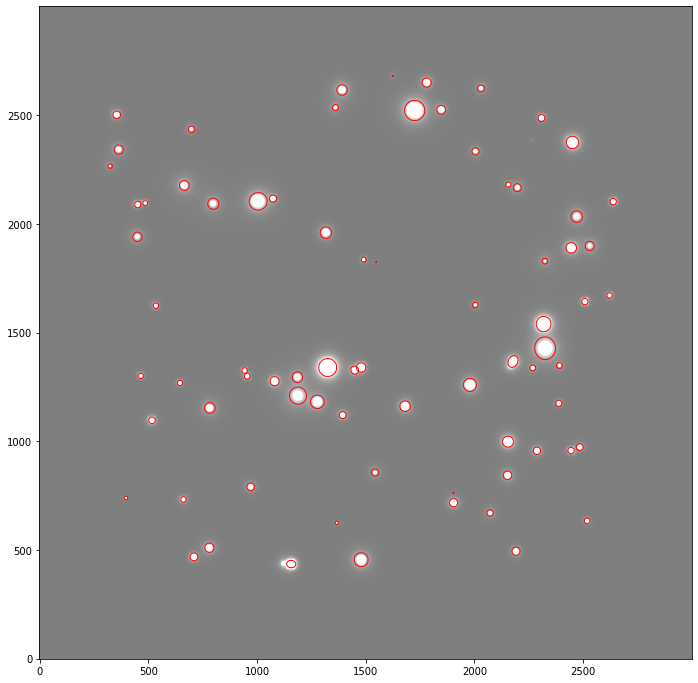

In [793]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots(figsize=(12,12))
m, s = np.mean(image_r), np.std(image_r)
im = ax.imshow(image_r[1000:4000,1000:4000], interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objs)):
    e = Ellipse(xy=(objs['x'][i]-1000, objs['y'][i]-1000),
                width=6*objs['a'][i],
                height=6*objs['b'][i],
                angle=objs['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [794]:
from sklearn.neighbors import KDTree
import seaborn as sns
from scipy.stats import binned_statistic

def spatial_closest_mag_1band(ra_data,dec_data,mag_data,
                              ra_true,dec_true,mag_true,true_id,
                              rmax=50,max_deltamag=1.0):
    X = np.zeros((len(ra_true),2))
    X[:,0] = ra_true
    X[:,1] = dec_true
    tree = KDTree(X,metric='euclidean')
    Y = np.zeros((len(ra_data),2))
    Y[:,0] = ra_data
    Y[:,1] = dec_data
    ind,dist= tree.query_radius(Y,r=rmax,return_distance=True)
    matched = np.zeros(len(ind),dtype=bool)
    ids = np.zeros(len(ind),dtype=true_id.dtype)
    dist_out = np.zeros(len(ind))
    for i, ilist in enumerate(ind):
        if len(ilist)>0:
            dmag = np.fabs(2.5*np.log10(mag_true[ilist])-2.5*np.log10(mag_data[i]))
            good_ind = np.argmin(dmag)
            ids[i]=true_id[ilist[good_ind]]
            dist_out[i]=dist[i][good_ind]
            if np.min(dmag)<max_deltamag:
                matched[i]=True
            else:
                matched[i]=False
        else:
            ids[i]=0
            matched[i]=False
            dist_out[i]=-99.
    return dist_out, ids,matched

def mystat(x):
    return np.percentile(x,75)-np.percentile(x,25)
def p75(x):
    return np.percentile(x,75)
def p25(x):
    return np.percentile(x,25)
def make_fancy_plot(mag1, mag2, x=None, y=None, hc=None, show_contours=False, bins=30, range=(15,30), xlabel='MAG_ISO',
    ylabel='TPHOT - MAG_ISO', savename=None, lbl='cold', color='blue', color2='darkblue',**kwargs):
    p1=sns.jointplot(mag1,mag2-mag1, kind='scatter',color=color,marginal_kws={'hist':True, 'kde': True},s=0.001,**kwargs)
    if show_contours:
        p1.plot_joint(sns.kdeplot)
    if (x is not None) and (y is not None) and (hc is None):
        dist=np.sqrt((x-2700)**2+(y-2700)**2)
        im = p1.ax_joint.scatter(mag1,mag2-mag1,s=0.5,c=dist)
        plt.colorbar(im, label='Distance to the center [px]')
    elif (x is None) & (y is None) & (hc is not None):
        p1.ax_joint.scatter(mag1[hc=='h'],(mag2-mag1)[hc=='h'],s=0.5,c='red')
        p1.ax_joint.scatter(mag1[hc=='c'],(mag2-mag1)[hc=='c'],s=0.5,c='blue')
    else:
        p1.ax_joint.scatter(mag1,mag2-mag1,s=1,c=color)
        return p1
    plt.legend([lbl])
    
    median_diff, be, _ = binned_statistic(mag1, mag2-mag1, statistic='median', bins=bins, range=range)
    p25_diff, be, _ = binned_statistic(mag1, mag2-mag1, statistic=p25, bins=bins, range=range)
    p75_diff, be, _ = binned_statistic(mag1, mag2-mag1, statistic=p75, bins=bins, range=range)
    p1.ax_joint.plot(0.5*be[1:]+0.5*be[:-1], median_diff, color=color2)
    p1.ax_joint.fill_between(0.5*(be[1:]+be[:-1]), p25_diff, p75_diff, alpha=0.5, color=color2)
    p1.ax_joint.set_xlabel(xlabel, fontsize=16)
    p1.ax_joint.set_ylabel(ylabel, fontsize=16)
    
    legend_properties = {'weight':'bold','size':8}
    legendMain=p1.ax_joint.legend(prop=legend_properties, labels=[lbl], loc='upper right')
    p1.ax_joint.add_artist(legendMain)
    
    if savename is not None:
        p1.savefig(savename)

In [795]:
for i in range(0, iter_tot):
    fname_out = os.path.join(base_path, 'output', f'detected_fake_{obj_type}_A2744_{myband}_{i}.fits.gz')
    fname_in = os.path.join(base_path, 'output', f'catalog_fake_{obj_type}_A2744_{i}.dat')
    if 'gal' in obj_type:
        fname_out = fname_out.replace('.fits.gz', f'_{gal_type}.fits.gz')
        fname_in = fname_in.replace('.dat', f'_{gal_type}.dat')
        #print(fname_out)
    aux = astropy.table.Table.read(fname_out)
    aux2 = astropy.table.Table.read(fname_in, format='ascii')
    dist, ids, matched = spatial_closest_mag_1band(aux['x'],aux['y'],aux['flux'],
                              aux2['X'],aux2['Y'],aux2[f'{myband}'],np.arange(len(tab_in)),
                              rmax=10,max_deltamag=2.0)
    print(i, np.count_nonzero(matched), len(aux), len(aux2))
    joint_table = astropy.table.hstack([aux[matched], aux2[ids][matched]])
    if i==0:
        total_tab = joint_table
    else:
        total_tab = astropy.table.vstack([total_tab, joint_table])

0 74 78 80
1 74 77 80
2 74 78 80
3 73 77 80
4 74 78 80
5 73 77 80
6 71 75 80
7 74 78 80
8 74 78 80
9 74 78 80
10 73 77 80
11 73 77 80
12 74 78 80
13 74 77 80
14 74 78 80
15 74 77 80
16 74 78 80
17 74 78 80
18 74 78 80
19 73 77 80
20 74 77 80
21 74 78 80
22 74 78 80
23 73 76 80
24 74 76 80
25 75 78 80
26 75 78 80
27 74 78 80
28 74 77 80
29 74 78 80
30 75 78 80
31 75 78 80
32 74 78 80
33 74 78 80
34 75 78 80
35 73 77 80
36 73 77 80
37 74 78 80
38 74 78 80
39 72 76 80


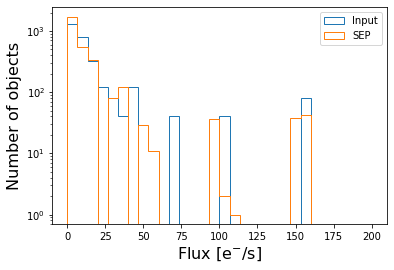

In [796]:
plt.hist(total_tab[f'{band}'], histtype='step', bins=30, range=(0,200), label='Input')
plt.hist(total_tab[f'flux'], histtype='step', bins=30, range=(0,200), label='SEP')
plt.xlabel('Flux [e$^{-}$/s]', fontsize=16)
plt.ylabel('Number of objects', fontsize=16)
plt.yscale('log')
plt.legend(loc='best')

In [797]:
print(1.0*len(total_tab)/(nobj*iter_tot))

0.9225


In [798]:
from scipy.stats import binned_statistic

In [799]:
def clipped_median(x, nmax_iter=1000, tol=0.01, max_sigma=1.):
    for i in range(nmax_iter):
        _sigma = np.std(x)
        _old_median = np.median(x)
        _new_median = np.median(x[(x>_old_median-max_sigma*_sigma) & (x<_old_median+max_sigma*_sigma)])
        if np.fabs(_old_median/_new_median-1) < tol:
            return _new_median
        else:
            x=x[(x>_old_median-max_sigma*_sigma) & (x<_old_median+max_sigma*_sigma)]
    return _new_median

In [800]:
median_diff, be, _ = binned_statistic(-2.5*np.log10(total_tab[f'{myband}'])+zeropoints[f'{myband}'],
            -2.5*np.log10(total_tab[f'{myband}'])+2.5*np.log10(total_tab['flux']), statistic=clipped_median)

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [801]:
import seaborn as sns

Text(18.75, 0.5, 'Input - measured')

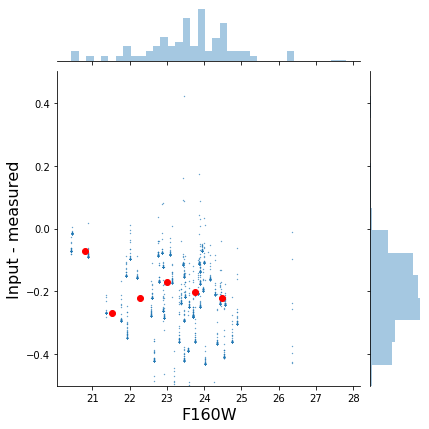

In [802]:
jgrid = sns.jointplot(-2.5*np.log10(total_tab[f'{myband}'])+zeropoints[f'{myband}'],
            -2.5*np.log10(total_tab[f'{myband}'])+2.5*np.log10(total_tab['flux']), kind='scatter', s=0.1, ylim=(-0.5,0.5))#, marginal_kws=dict(bins=500))

#jgrid.ax_joint.scatter(-2.5*np.log10(tab_in[f'{band}'][ids][matched])+zeropoints[f'{band}'],
#            -2.5*np.log10(tab_in[f'{band}'][ids][matched])+2.5*np.log10(tab_out['flux'][matched]), s=1)
jgrid.ax_joint.plot(0.5*(be[1:]+be[:-1]), median_diff, 'ro')
jgrid.ax_joint.set_xlabel('F160W', fontsize=16)
jgrid.ax_joint.set_ylabel('Input - measured', fontsize=16)
#plt.ylim(-0.4,0.1)